In [1]:
'''
This code generate rarefaction curves.
It does so by comparing the raw results from the microscopy, flowcam, and computer predictions.
It resamples the individual taxa with increasingly larger sample sizes and counts the number of taxa in each sample.
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [36]:
#FUNCTIONS
def get_chao1(df):
    # Sample Data: Species names and their counts (can be from a DataFrame)
    # Let's assume this is a dataset with columns: 'species' and 'count'
    
    # Calculate F1 (singletons) and F2 (doubletons)
    F1 = (df['countSample'] == 1).sum()  # Number of species that appear exactly once
    F2 = (df['countSample'] == 2).sum()  # Number of species that appear exactly twice
    
    # Total observed species (S_obs)
    S_obs = df.shape[0]  # The number of unique species observed
    
    # Chao1 estimator formula
    S_Chao1 = S_obs + (F1 * (F1 - 1)) / (2 * (F2 + 1))
    
    # Output the results
    print(f"Observed species (S_obs): {S_obs}")
    print(f"Singletons (F1): {F1}")
    print(f"Doubletons (F2): {F2}")
    print(f"Chao1 Estimate: {S_Chao1}")
    return S_Chao1

def get_chao2(df):
    # Pivot the dataframe to get species counts for each sample
    df_pivot = df.pivot(index='FlowCamID', columns='newName', values='countSample').fillna(0)
    
    # Convert the counts to boolean (0 = species absent, >0 = species present)
    species_counts = df_pivot.astype(bool).sum(axis=0)  # Number of samples each species appears in
    
    # Total number of observed species (S_obs)
    S_obs = len(species_counts)
    
    # Count the number of singletons (species observed exactly once across all samples)
    n1 = sum(1 for count in species_counts if count == 1)
    
    # Count the number of doubletons (species observed exactly twice across all samples)
    n2 = sum(1 for count in species_counts if count == 2)
    
    # Apply the Chao2 formula
    chao2 = S_obs + (n1 ** 2) / (2 * n2) if n2 > 0 else S_obs  # Avoid division by zero if n2 is zero
    
    return chao2


def get_increment(max_num, num_of_intervals):
    divider = max_num - max_num % num_of_intervals    
    return divider / num_of_intervals

def rarefaction_curve(df, max_sample_size, num_of_intervals, num_iterations=1000):
    print('num of species: ', len(df))
    print(df['newName'])
    newNames = df['newName'].to_numpy()
    probs = df['probs'].to_numpy()
    species_counts = df['countSample'].values  # Counts of each species
    name_basket = []
    for i, newName in enumerate(newNames):
        for _ in range(species_counts[i]):
            name_basket.append(newName)
    richness_list = []  # List to store species richness for each sample size
    increment = get_increment(max_sample_size, num_of_intervals)
    print("increment: ", increment)
    for sample_size in range(0, max_sample_size + 1):
        if not sample_size % increment == 0:
            continue
        species_richness = []

        for _ in range(num_iterations):
            # Randomly sample individuals from the species counts
            sampled =np.random.choice(name_basket, sample_size, replace=False)
            # Count the number of unique species observed in this random sample
            observed_species = len(np.unique(sampled))  # Species present if count > 0
            species_richness.append(observed_species)
        richness_list.append(np.mean(species_richness))
        # if np.mean(species_richness) >= len(df):
        #     break
        # Calculate the average species richness for the current sample size
        # print("mean of species_richness: ", np.mean(species_richness))
    return richness_list, increment

def plot_rarefaction_curve(df, chao1, num_of_intervals):

    sum_counts = df['countSample'].sum()
    df['probs'] = df['countSample'] / sum_counts
    

    
    # Get the rarefaction curve
    richness, increment = rarefaction_curve(df, min(sum_counts, 8525), 200)
    # Plot the rarefaction curve
    plt.figure(figsize=(8, 6))
    plt.plot(np.array(range(len(richness))) * increment, richness)
    plt.axhline(y=chao1, color='red', linestyle='--', linewidth=2)
    plt.axhline(y=len(df), color='red', linestyle='-', linewidth=2)
    plt.title('Rarefaction Curve')
    plt.xlabel('Number of Individuals Sampled')
    plt.ylabel('Species Richness (Observed Species)')
    plt.grid(True)
    plt.show()
    plt.close()
    return richness, sum_counts, increment, len(df)

def get_redundant_count_names(abunddf, countdf, type):
    typeAbunddf = abunddf[abunddf['type'] == type]
    abundNames = typeAbunddf['newName'].unique()
    countNames = countdf['newName'].unique()
    unique_to_abund = np.setdiff1d(abundNames, countNames)
    unique_to_count = np.setdiff1d(countNames, abundNames)
    print("unique to abund: ", unique_to_abund)
    print("unique to count: ", unique_to_count)
    return unique_to_count


In [3]:

nameChangesFile = pd.ExcelFile('./FinnisData-20241007T133632Z-001/FinnisData/Method Paper/methodPaperZooNameChanges.xlsx')
sheet_names = nameChangesFile.sheet_names
nameChanges = pd.read_excel(nameChangesFile, sheet_names[1])
ogNames = nameChanges['flowcamName'].to_numpy()
newNames = nameChanges['newName'].to_numpy()
changeDict = {}
for i, ogname in enumerate(ogNames):
    changeDict[ogname] = newNames[i]

changeDict['Chaetognatha (juvenile or n.s.)']= 'Chaetognatha'
changeDict['Sarsia_spp_medusa']= 'Sarsia spp. (medusa)'


In [4]:
datadf = pd.read_excel('./FinnisData-20241007T133632Z-001/FinnisData/Method Paper/methodPaperDataForFigures.xlsx')

In [5]:
# this cleans the the redundant taxa from the microscopy data (like eggs)

hm_rawcounts_df = pd.read_excel('./FinnisData-20241007T133632Z-001/FinnisData/Method Paper/microscopyDataMethodPaper_RawCounts.xlsx')
hm_rawcounts_df = hm_rawcounts_df[['FlowCamID', 'newName', 'regionYear', 'Subsample fraction', 'countSample']]
#check which names are in rawcounts but not in the abundance data sheet. Remove them and print them.
hm_rawcounts_df_redundant_names = get_redundant_count_names(datadf, hm_rawcounts_df, 'MC')
print(len(hm_rawcounts_df['newName'].unique()))
hm_rawcounts_df = hm_rawcounts_df[~hm_rawcounts_df['newName'].isin(hm_rawcounts_df_redundant_names)]
len(hm_rawcounts_df['newName'].unique())

unique to abund:  []
unique to count:  ['Decapoda: Distribute abundances between non-brachyura and brachyura'
 'Egg mass: REMOVE' 'Invertebrate (egg, trochophore larvae)']
50


47

In [6]:
#rename problem taxa

newName_removals = ['Alciopidae sp.', 'Neoturris spp. (medusa)', 'Scyphozoa (medusa)']

newName_changes = {'Ctenophora (juvenile/adult)': 'Ctenophora (larvae)',
                  'Amphipoda- epibenthic': 'Amphipoda',
                   'Calycophorae (nectophore)': 'Siphonophorae (nectophore)',
                   'Ctenophora larvae': 'Ctenophora (larvae)'
                  }


hm_rawcounts_df = hm_rawcounts_df[~hm_rawcounts_df['newName'].isin(newName_removals)]
hm_rawcounts_df = hm_rawcounts_df.replace(newName_changes)
hm_names = hm_rawcounts_df['newName'].unique()
hm_names.sort()
print(len(hm_names))
hm_names

43


array(['Acartia spp.', 'Aglantha spp. (medusa)', 'Amphipoda',
       'Ascidiacea (larvae)', 'Bivalvia (larvae)', 'Bryozoa (larvae)',
       'Calanoida (ci-ciii)', 'Calanus spp.', 'Centropages spp.',
       'Chaetognatha', 'Cirripedia (larvae)', 'Copepoda (nauplii)',
       'Corycaeidae', 'Ctenophora (larvae)',
       'Decapoda- brachyura (larvae)', 'Decapoda- non-brachyura (larvae)',
       'Echinodermata (larvae)', 'Epilabidocera spp.', 'Eurytemora spp.',
       'Evadne spp.', 'Fritillaria spp.', 'Gastropoda (larvae/Limacina)',
       'Harpacticoida- epibenthic', 'Hydrozoa (medusa)',
       'Isopoda (larvae)', 'Leuckartiara spp. (medusa)',
       'Microcalanus spp.', 'Obelia spp. (medusa)', 'Oikopleura spp.',
       'Oithona spp.', 'Osteichthyes (larvae)', 'Paracalanus spp.',
       'Platyhelminthes/Nemertea (juvenile)',
       'Platyhelminthes/Nemertea (larvae)', 'Podon/Pleopsis spp.',
       'Polychaeta (larvae)', 'Pseudocalanus spp.',
       'Pseudodiaptomus spp.', 'Sarsia spp. (me

In [ ]:
# calculate and plot curves for microscopy (HM)
regionYears = hm_rawcounts_df['regionYear'].unique()
print(regionYears)
hm_region_richness = {}
hm_sum_counts = {}
hm_increments = {}
hm_total_species = {}
for regionYear in regionYears:
    print(regionYear)
    regionYear_df = hm_rawcounts_df[hm_rawcounts_df['regionYear'] == regionYear]
    sample_counts = regionYear_df.groupby('newName', as_index=False)['countSample'].sum()
    print(np.sum(sample_counts['countSample'].to_numpy()))
    chao1 = get_chao1(sample_counts)
    hm_region_richness[regionYear], hm_sum_counts[regionYear], hm_increments[regionYear], hm_total_species[regionYear] = plot_rarefaction_curve(sample_counts, chao1, 20)

['NL 2021' 'NL 2020' 'Gulf 2020' 'Pac 21']
NL 2021
5855
Observed species (S_obs): 25
Singletons (F1): 2
Doubletons (F2): 1
Chao1 Estimate: 25.5
num of species:  25
0                     Acartia spp.
1           Aglantha spp. (medusa)
2                Bivalvia (larvae)
3                 Bryozoa (larvae)
4              Calanoida (ci-ciii)
5                     Calanus spp.
6                 Centropages spp.
7                     Chaetognatha
8           Echinodermata (larvae)
9                  Eurytemora spp.
10                     Evadne spp.
11                Fritillaria spp.
12    Gastropoda (larvae/Limacina)
13       Harpacticoida- epibenthic
14               Hydrozoa (medusa)
15               Microcalanus spp.
16            Obelia spp. (medusa)
17                 Oikopleura spp.
18                    Oithona spp.
19             Podon/Pleopsis spp.
20             Polychaeta (larvae)
21              Pseudocalanus spp.
22            Sarsia spp. (medusa)
23                     Temora s

In [8]:
hi_rawcounts_df = pd.read_excel('./FinnisData-20241007T133632Z-001/FinnisData/Method Paper/flowcamDataMethodPaper_RawCounts.xlsx')
hi_rawcounts_df = hi_rawcounts_df[['qaSampleID', 'originalNames', 'dataset', 'fracSampleCleaned', 'count']]
hi_rawcounts_df = hi_rawcounts_df.rename(columns={'qaSampleID': 'FlowCamID', 'originalNames': 'newName', 'dataset':'regionYear', 'count': 'countSample'})
hi_rawcounts_df['newName'] = hi_rawcounts_df['newName'].replace(changeDict)
hi_rawcounts_df['regionYear'] = hi_rawcounts_df['regionYear'].replace({'Newfoundland 2020': 'NL 2020', 'Pacific June 2021': 'Pacific', 'Newfoundland 2021': 'NL 2021', 'Gulf 2020': 'Gulf'})
hi_rawcounts_df_redundant_names = get_redundant_count_names(datadf, hi_rawcounts_df, 'FC')
hi_rawcounts_df_redundant_names = hi_rawcounts_df_redundant_names[hi_rawcounts_df_redundant_names != 'Oncaeidae_Civ-vi']
hi_rawcounts_df_redundant_names = hi_rawcounts_df_redundant_names[hi_rawcounts_df_redundant_names != 'Sarsia spp. (medusa)']
print(len(hi_rawcounts_df['newName'].unique()))
hi_rawcounts_df = hi_rawcounts_df[~hi_rawcounts_df['newName'].isin(hi_rawcounts_df_redundant_names)]
print(len(hi_rawcounts_df['newName'].unique()))
hi_names = hi_rawcounts_df['newName'].unique()
hi_names.sort()
hi_names

unique to abund:  []
unique to count:  ['Calanoida (unid)' 'Copepoda (unid)' 'Cyclopoida (unid)'
 'Invertebrate (egg, trochophore larvae)' 'Oncaeidae_Civ-vi'
 'Osteichthyes egg' 'Osteichthyes_eggs' 'Sarsia spp. (medusa)'
 'Zooplankton (unid)']
55
48


array(['Acartia spp.', 'Aglantha spp. (medusa)', 'Amphipoda',
       'Anthoathecata (medusa)', 'Ascidiacea (larvae)',
       'Bivalvia (larvae)', 'Bryozoa (larvae)', 'Calanoida (ci-ciii)',
       'Calanus spp.', 'Calycophorae (nectophore)', 'Centropages spp.',
       'Chaetognatha', 'Chiridius spp.', 'Cirripedia (larvae)',
       'Cnidaria (larvae)', 'Copepoda (nauplii)', 'Corycaeidae',
       'Ctenophora larvae', 'Decapoda- brachyura (larvae)',
       'Decapoda- non-brachyura (larvae)', 'Echinodermata (larvae)',
       'Euphysa spp. (medusa)', 'Eurytemora spp.', 'Evadne spp.',
       'Foraminifera', 'Fritillaria spp.', 'Gastropoda (larvae/Limacina)',
       'Harpacticoida- epibenthic', 'Hydrozoa (medusa)', 'Metridia spp.',
       'Microcalanus spp.', 'Microsetella spp.', 'Monstrillidae',
       'Obelia spp. (medusa)', 'Oikopleura spp.', 'Oithona spp.',
       'Oncaeidae_Civ-vi', 'Osteichthyes (larvae)', 'Ostracoda',
       'Paracalanus spp.', 'Podon/Pleopsis spp.', 'Polychaeta (larvae

In [11]:

hi_rawcounts_df = hi_rawcounts_df.replace(newName_changes)
flow_names = hi_rawcounts_df['newName'].unique()
flow_names.sort()
flow_names

array(['Acartia spp.', 'Aglantha spp. (medusa)', 'Amphipoda',
       'Anthoathecata (medusa)', 'Ascidiacea (larvae)',
       'Bivalvia (larvae)', 'Bryozoa (larvae)', 'Calanoida (ci-ciii)',
       'Calanus spp.', 'Centropages spp.', 'Chaetognatha',
       'Chiridius spp.', 'Cirripedia (larvae)', 'Cnidaria (larvae)',
       'Copepoda (nauplii)', 'Corycaeidae', 'Ctenophora (larvae)',
       'Decapoda- brachyura (larvae)', 'Decapoda- non-brachyura (larvae)',
       'Echinodermata (larvae)', 'Euphysa spp. (medusa)',
       'Eurytemora spp.', 'Evadne spp.', 'Foraminifera',
       'Fritillaria spp.', 'Gastropoda (larvae/Limacina)',
       'Harpacticoida- epibenthic', 'Hydrozoa (medusa)', 'Metridia spp.',
       'Microcalanus spp.', 'Microsetella spp.', 'Monstrillidae',
       'Obelia spp. (medusa)', 'Oikopleura spp.', 'Oithona spp.',
       'Oncaeidae_Civ-vi', 'Osteichthyes (larvae)', 'Ostracoda',
       'Paracalanus spp.', 'Podon/Pleopsis spp.', 'Polychaeta (larvae)',
       'Pseudocalanus s

In [12]:
hi_rawcounts_df[hi_rawcounts_df['newName'] == 'Oncaeidae_Civ-vi']

,FlowCamID,newName,regionYear,fracSampleCleaned,countSample
235,21-10-5-NL-S1-Z17-1406-250,Oncaeidae_Civ-vi,NL 2021,1.0,1
261,21-10-5-NL-S1-Z41-854-250,Oncaeidae_Civ-vi,NL 2021,1.0,4
316,21-10-6-NL-S1-Z17-802-250,Oncaeidae_Civ-vi,NL 2021,1.0,1


In [13]:
pacific_flow_names = hi_rawcounts_df[hi_rawcounts_df['regionYear'] == 'Pacific']['newName'].unique()
# print(pacific_flow_names)
pacific_mic_names = hm_rawcounts_df[hm_rawcounts_df['regionYear'] == 'Pac 21']['newName'].unique()
unique_to_flow = np.setdiff1d(pacific_flow_names, pacific_mic_names)
unique_to_mic = np.setdiff1d(pacific_mic_names, pacific_flow_names)
print(unique_to_flow)
print(unique_to_mic)

['Calanus spp.' 'Euphysa spp. (medusa)' 'Ostracoda']
['Amphipoda' 'Chaetognatha' 'Epilabidocera spp.'
 'Harpacticoida- epibenthic' 'Isopoda (larvae)'
 'Leuckartiara spp. (medusa)' 'Obelia spp. (medusa)'
 'Platyhelminthes/Nemertea (juvenile)' 'Platyhelminthes/Nemertea (larvae)'
 'Sarsia spp. (medusa)' 'Scyphozoa (larvae)']


In [14]:
hm_rawcounts_df[(hm_rawcounts_df['newName'].isin(unique_to_mic)) & (hm_rawcounts_df['regionYear'] == 'Pac 21')]

,FlowCamID,newName,regionYear,Subsample fraction,countSample
460,AMMP_PA_S04W01_20210609LT_250um,Harpacticoida- epibenthic,Pac 21,0.039062,1
466,AMMP_PA_S04W01_20210609LT_250um,Platyhelminthes/Nemertea (juvenile),Pac 21,0.039062,1
487,AMMP_PA_S04W15_20210609LT_250um,Obelia spp. (medusa),Pac 21,0.031250,1
521,AMMP_PA_S04W15_20210609LT_250um,Chaetognatha,Pac 21,1.000000,1
522,AMMP_PA_S04W15_20210609LT_250um,Leuckartiara spp. (medusa),Pac 21,1.000000,2
562,AMMP_PA_S04W20_20210609LT_250um,Sarsia spp. (medusa),Pac 21,1.000000,1
565,AMMP_PA_S04W20_20210609LT_250um,Scyphozoa (larvae),Pac 21,1.000000,1
602,AMMP_PA_S04W01_20210609HT_250um,Chaetognatha,Pac 21,1.000000,1
639,AMMP_PA_S04W15_20210609HT_250um,Sarsia spp. (medusa),Pac 21,1.000000,1
662,AMMP_PA_S04W20_20210609HT_250um,Isopoda (larvae),Pac 21,0.046875,1


In [15]:
hi_rawcounts_df[(hi_rawcounts_df['newName'].isin(unique_to_flow)) & (hi_rawcounts_df['regionYear'] == 'Pacific')]

,FlowCamID,newName,regionYear,fracSampleCleaned,countSample
640,AMMP_Pacific_S04W01_250um_Low_2021-06-09,Calanus spp.,Pacific,0.107273,1
650,AMMP_Pacific_S04W01_250um_Low_2021-06-09,Euphysa spp. (medusa),Pacific,0.107273,1
658,AMMP_Pacific_S04W01_250um_Low_2021-06-09,Ostracoda,Pacific,0.107273,4
686,AMMP_Pacific_S04W15_250um_Low_2021-06-09,Ostracoda,Pacific,0.146168,3
693,AMMP_Pacific_S04W15_250um_Low_2021-06-09,Euphysa spp. (medusa),Pacific,1.000000,1
698,AMMP_Pacific_S04W20_250um_Low_2021-06-09,Calanus spp.,Pacific,0.111045,1
706,AMMP_Pacific_S04W20_250um_Low_2021-06-09,Euphysa spp. (medusa),Pacific,0.111045,1
713,AMMP_Pacific_S04W20_250um_Low_2021-06-09,Ostracoda,Pacific,0.111045,2
725,AMMP_Pacific_S04W01_250um_High_2021-06-09,Calanus spp.,Pacific,0.086603,1
759,AMMP_Pacific_S04W15_250um_High_2021-06-09,Calanus spp.,Pacific,0.113390,1


In [16]:
hi_rawcounts_df[hi_rawcounts_df['regionYear'] == 'NL 2021']['countSample'].sum()


8525

['NL 2020' 'NL 2021' 'Gulf' 'Pacific']
NL 2020
41043
Observed species (S_obs): 27
Singletons (F1): 4
Doubletons (F2): 3
Chao1 Estimate: 28.5
num of species:  27
0                         Acartia spp.
1               Aglantha spp. (medusa)
2                            Amphipoda
3               Anthoathecata (medusa)
4                    Bivalvia (larvae)
5                         Calanus spp.
6                     Centropages spp.
7                         Chaetognatha
8                       Chiridius spp.
9                    Cnidaria (larvae)
10    Decapoda- non-brachyura (larvae)
11              Echinodermata (larvae)
12                     Eurytemora spp.
13                         Evadne spp.
14                    Fritillaria spp.
15        Gastropoda (larvae/Limacina)
16           Harpacticoida- epibenthic
17                   Hydrozoa (medusa)
18                       Metridia spp.
19                Obelia spp. (medusa)
20                     Oikopleura spp.
21                  

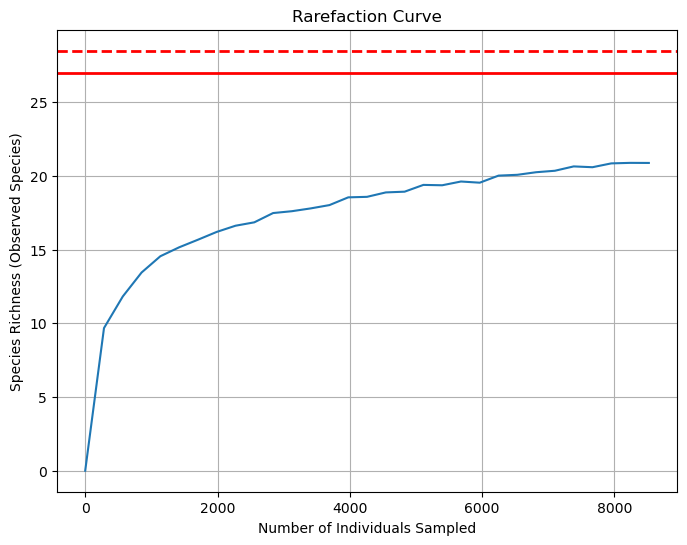

NL 2021
8525
Observed species (S_obs): 29
Singletons (F1): 2
Doubletons (F2): 2
Chao1 Estimate: 29.333333333333332
num of species:  29
0                         Acartia spp.
1               Aglantha spp. (medusa)
2                    Bivalvia (larvae)
3                     Bryozoa (larvae)
4                  Calanoida (ci-ciii)
5                         Calanus spp.
6                     Centropages spp.
7                         Chaetognatha
8     Decapoda- non-brachyura (larvae)
9               Echinodermata (larvae)
10                     Eurytemora spp.
11                         Evadne spp.
12                        Foraminifera
13                    Fritillaria spp.
14        Gastropoda (larvae/Limacina)
15           Harpacticoida- epibenthic
16                   Hydrozoa (medusa)
17                   Microcalanus spp.
18                       Monstrillidae
19                     Oikopleura spp.
20                        Oithona spp.
21                    Oncaeidae_Civ-vi
22     

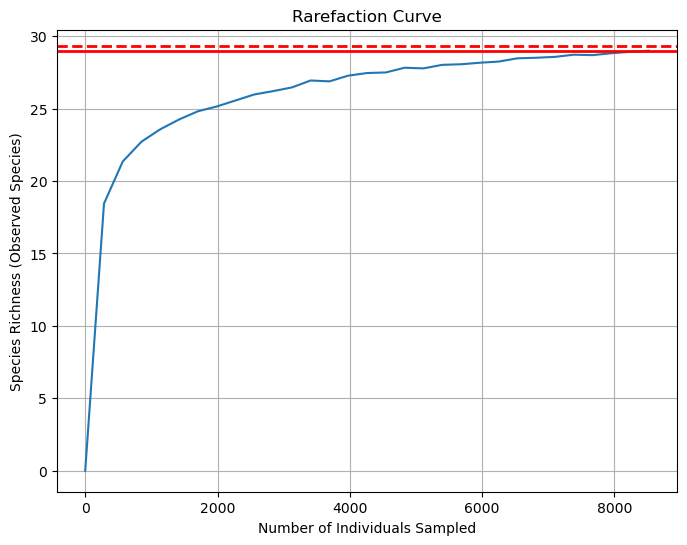

Gulf
39036
Observed species (S_obs): 32
Singletons (F1): 6
Doubletons (F2): 2
Chao1 Estimate: 37.0
num of species:  32
0                         Acartia spp.
1                  Ascidiacea (larvae)
2                    Bivalvia (larvae)
3                     Bryozoa (larvae)
4                  Calanoida (ci-ciii)
5                     Centropages spp.
6                         Chaetognatha
7                  Cirripedia (larvae)
8                    Cnidaria (larvae)
9                   Copepoda (nauplii)
10        Decapoda- brachyura (larvae)
11    Decapoda- non-brachyura (larvae)
12              Echinodermata (larvae)
13                     Eurytemora spp.
14                         Evadne spp.
15                    Fritillaria spp.
16        Gastropoda (larvae/Limacina)
17           Harpacticoida- epibenthic
18                   Hydrozoa (medusa)
19                   Microsetella spp.
20                       Monstrillidae
21                Obelia spp. (medusa)
22                     

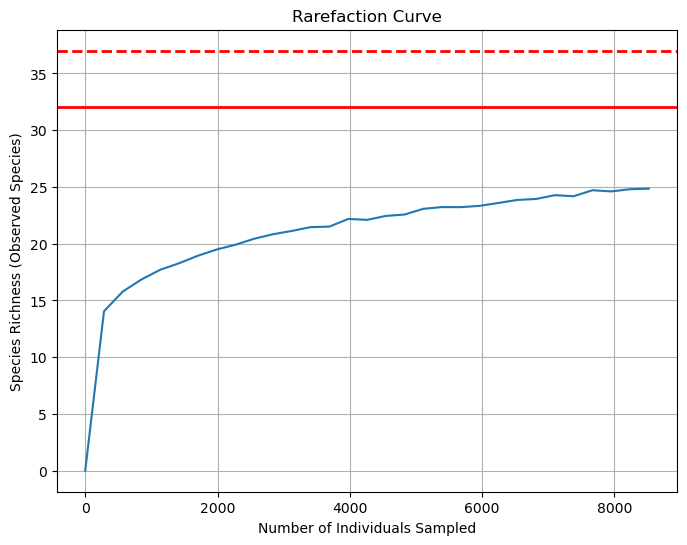

Pacific
10220
Observed species (S_obs): 29
Singletons (F1): 2
Doubletons (F2): 0
Chao1 Estimate: 30.0
num of species:  29
0                         Acartia spp.
1                  Ascidiacea (larvae)
2                    Bivalvia (larvae)
3                     Bryozoa (larvae)
4                  Calanoida (ci-ciii)
5                         Calanus spp.
6                     Centropages spp.
7                  Cirripedia (larvae)
8                   Copepoda (nauplii)
9                          Corycaeidae
10                 Ctenophora (larvae)
11        Decapoda- brachyura (larvae)
12    Decapoda- non-brachyura (larvae)
13              Echinodermata (larvae)
14               Euphysa spp. (medusa)
15                         Evadne spp.
16                    Fritillaria spp.
17        Gastropoda (larvae/Limacina)
18                   Hydrozoa (medusa)
19                     Oikopleura spp.
20                        Oithona spp.
21               Osteichthyes (larvae)
22                  

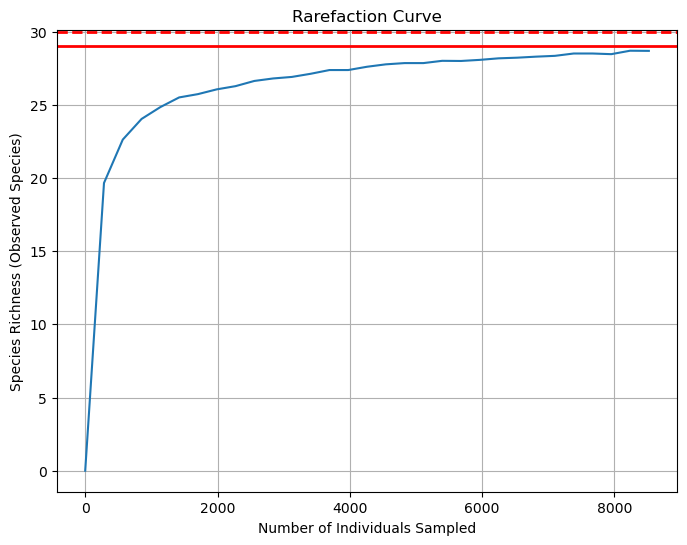

In [17]:
regionYears = hi_rawcounts_df['regionYear'].unique()
print(regionYears)
hi_region_richness = {}
hi_sum_counts = {}
hi_increments = {}
hi_total_species = {}
for regionYear in regionYears:
    print(regionYear)
    regionYear_df = hi_rawcounts_df[hi_rawcounts_df['regionYear'] == regionYear]
    sample_counts = regionYear_df.groupby('newName', as_index=False)['countSample'].sum()
    print(np.sum(sample_counts['countSample'].to_numpy()))
    chao1 = get_chao1(sample_counts)
    hi_region_richness[regionYear], hi_sum_counts[regionYear], hi_increments[regionYear], hi_total_species[regionYear] = plot_rarefaction_curve(sample_counts, chao1, 20)

In [18]:
cidf = datadf = pd.read_excel('strat4_5000.xlsx')
cidf = cidf[cidf['type'] == 'CI']
ci_rawcounts_df = cidf.rename(columns={'abund': 'countSample'})
ci_rawcounts_df = ci_rawcounts_df.replace(newName_changes)

['NL 2021' 'Gulf 2020' 'NL 2020' 'Pac 21']
NL 2021
8362
Observed species (S_obs): 24
Singletons (F1): 0
Doubletons (F2): 1
Chao1 Estimate: 24.0
num of species:  24
0                     Acartia spp.
1                Bivalvia (larvae)
2                 Bryozoa (larvae)
3              Calanoida (ci-ciii)
4                     Calanus spp.
5                 Centropages spp.
6                     Chaetognatha
7              Cirripedia (larvae)
8               Copepoda (nauplii)
9           Echinodermata (larvae)
10           Euphausiacea (larvae)
11          Euphausiacea (nauplii)
12                     Evadne spp.
13                Fritillaria spp.
14    Gastropoda (larvae/Limacina)
15       Harpacticoida- epibenthic
16               Microcalanus spp.
17            Obelia spp. (medusa)
18                 Oikopleura spp.
19                    Oithona spp.
20             Podon/Pleopsis spp.
21             Polychaeta (larvae)
22              Pseudocalanus spp.
23                     Temora s

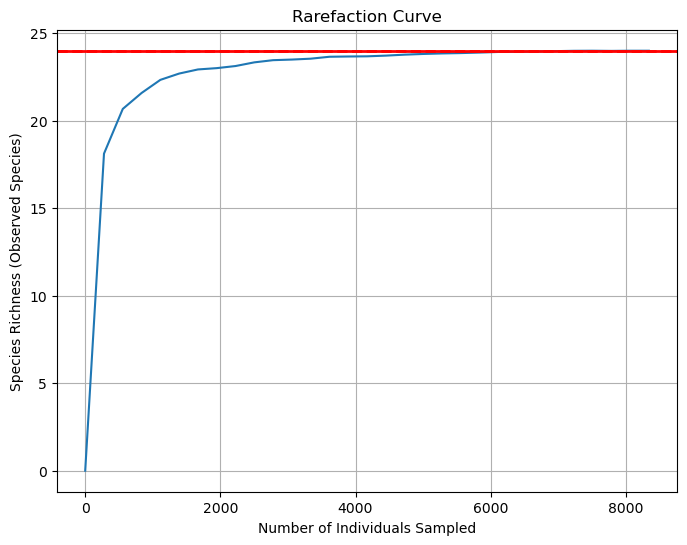

Gulf 2020
39010
Observed species (S_obs): 29
Singletons (F1): 0
Doubletons (F2): 0
Chao1 Estimate: 29.0
num of species:  29
0                         Acartia spp.
1                  Ascidiacea (larvae)
2                    Bivalvia (larvae)
3                     Bryozoa (larvae)
4                  Calanoida (ci-ciii)
5                         Calanus spp.
6                     Centropages spp.
7                  Cirripedia (larvae)
8                   Copepoda (nauplii)
9         Decapoda- brachyura (larvae)
10    Decapoda- non-brachyura (larvae)
11              Echinodermata (larvae)
12                     Eurytemora spp.
13                         Evadne spp.
14                    Fritillaria spp.
15        Gastropoda (larvae/Limacina)
16           Harpacticoida- epibenthic
17                   Hydrozoa (medusa)
18                     Labidocera spp.
19                Obelia spp. (medusa)
20                        Oithona spp.
21               Osteichthyes (larvae)
22                

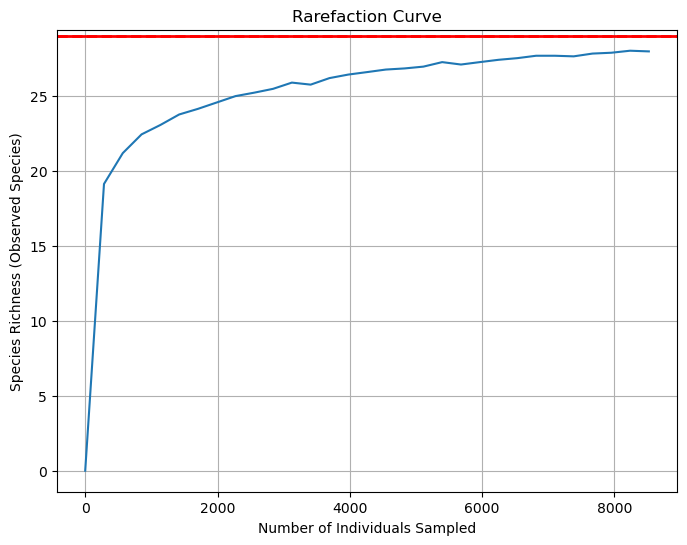

NL 2020
40923
Observed species (S_obs): 24
Singletons (F1): 1
Doubletons (F2): 1
Chao1 Estimate: 24.0
num of species:  24
0                     Acartia spp.
1                Bivalvia (larvae)
2                 Bryozoa (larvae)
3              Calanoida (ci-ciii)
4                     Calanus spp.
5                 Centropages spp.
6                     Chaetognatha
7              Cirripedia (larvae)
8               Copepoda (nauplii)
9           Echinodermata (larvae)
10           Euphausiacea (larvae)
11          Euphausiacea (nauplii)
12                 Eurytemora spp.
13                     Evadne spp.
14                Fritillaria spp.
15    Gastropoda (larvae/Limacina)
16       Harpacticoida- epibenthic
17               Microcalanus spp.
18                 Oikopleura spp.
19                    Oithona spp.
20             Podon/Pleopsis spp.
21             Polychaeta (larvae)
22              Pseudocalanus spp.
23                     Temora spp.
Name: newName, dtype: object
increment

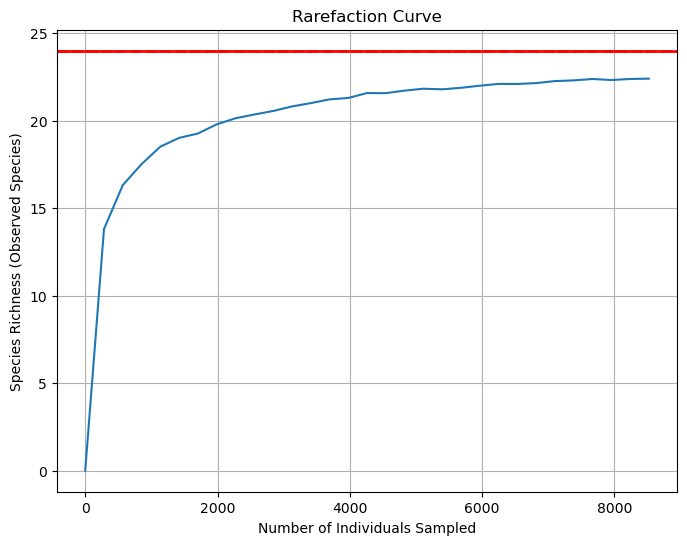

Pac 21
9965
Observed species (S_obs): 25
Singletons (F1): 0
Doubletons (F2): 0
Chao1 Estimate: 25.0
num of species:  25
0                          Acartia spp.
1                   Ascidiacea (larvae)
2                     Bivalvia (larvae)
3                      Bryozoa (larvae)
4                   Calanoida (ci-ciii)
5                      Centropages spp.
6                   Cirripedia (larvae)
7                    Copepoda (nauplii)
8                           Corycaeidae
9          Decapoda- brachyura (larvae)
10     Decapoda- non-brachyura (larvae)
11               Echinodermata (larvae)
12                          Evadne spp.
13                     Fritillaria spp.
14         Gastropoda (larvae/Limacina)
15                    Hydrozoa (medusa)
16                      Oikopleura spp.
17                         Oithona spp.
18                     Paracalanus spp.
19    Platyhelminthes/Nemertea (larvae)
20                  Podon/Pleopsis spp.
21                  Polychaeta (larvae)


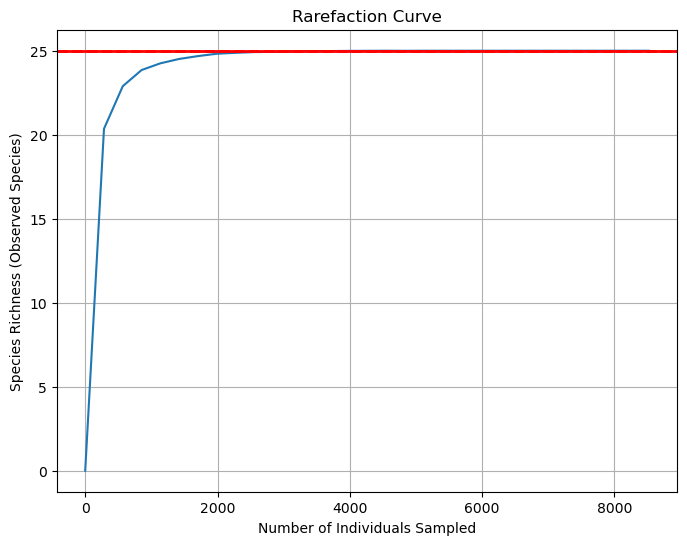

In [19]:
regionYears = ci_rawcounts_df['regionYear'].unique()
print(regionYears)
ci_rawcounts_df['countSample'] = ci_rawcounts_df['countSample'].astype(int)
ci_region_richness = {}
ci_sum_counts = {}
ci_increments = {}
ci_total_species = {}
for regionYear in regionYears:
    print(regionYear)
    regionYear_df = ci_rawcounts_df[ci_rawcounts_df['regionYear'] == regionYear]
    sample_counts = regionYear_df.groupby('newName', as_index=False)['countSample'].sum()
    print(np.sum(sample_counts['countSample'].to_numpy()))
    chao1 = get_chao1(sample_counts)
    ci_region_richness[regionYear], ci_sum_counts[regionYear], ci_increments[regionYear], ci_total_species[regionYear] = plot_rarefaction_curve(sample_counts, chao1, 20)

In [20]:
#changing regionYear keys to their new names

# Define a mapping of old keys to new keys
key_mapping = {'Newfoundland 2020': 'NL 2020', 'Pac 21': 'Pacific', 'Newfoundland 2021': 'NL 2021', 'Gulf 2020': 'Gulf'}

# # Replace keys using dictionary comprehension
hm_region_richness = {key_mapping.get(k, k): v for k, v in hm_region_richness.items()}
hm_increments = {key_mapping.get(k, k): v for k, v in hm_increments.items()}
hm_total_species = {key_mapping.get(k, k): v for k, v in hm_total_species.items()}
ci_region_richness = {key_mapping.get(k, k): v for k, v in ci_region_richness.items()}
ci_increments = {key_mapping.get(k, k): v for k, v in ci_increments.items()}
ci_total_species = {key_mapping.get(k, k): v for k, v in ci_total_species.items()}

In [21]:
np.array(range(len(richness))) * hi_increments[regionYear]

NameError: name 'richness' is not defined

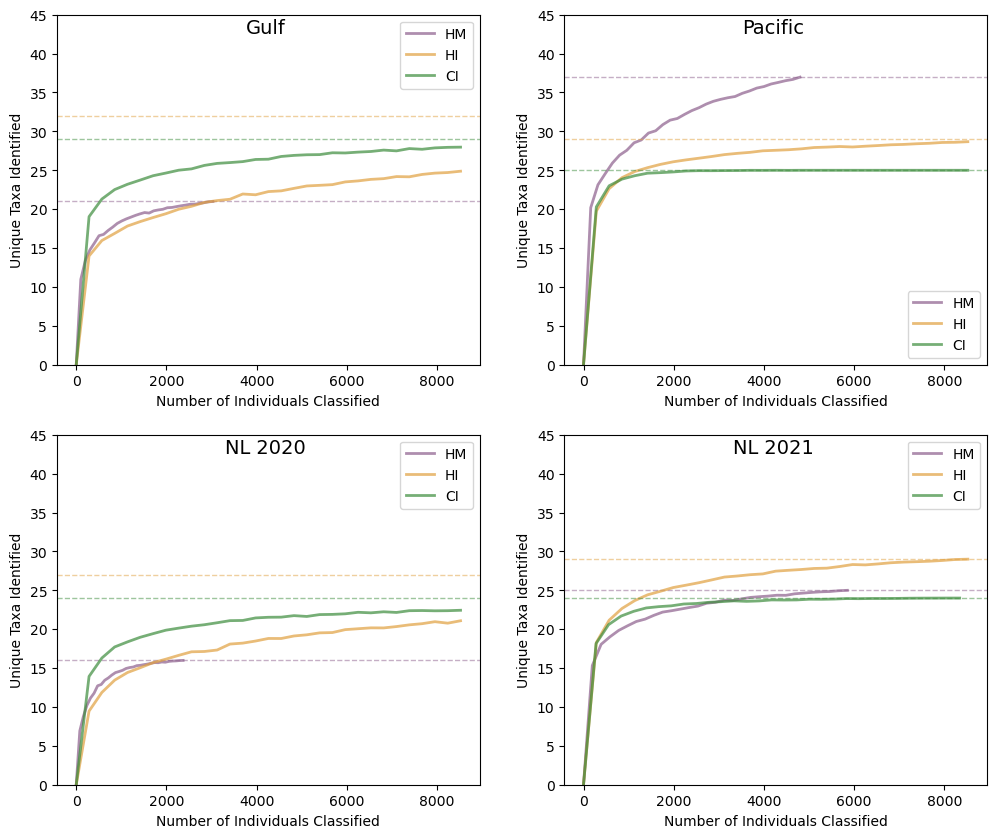

In [69]:
regionYears = ['Gulf', 'Pacific', 'NL 2020', 'NL 2021']
colors = ['#75ba75', '#fec76f', '#be95be']
colors = ['#3c8c3c', '#e0a03f', '#8c5e8c']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for r, regionYear in enumerate(regionYears):
    row = r // 2  # Determine the row index
    col = r % 2   # Determine the column index
    ax = axes[row, col]  # Access the correct subplot
    richness = hm_region_richness[regionYear]
    ax.plot(np.array(range(len(richness))) * hm_increments[regionYear], richness, alpha = .7, label='HM', linewidth=2, color=colors[2])
    ax.axhline(y=hm_total_species[regionYear], color=colors[2], linestyle='--', linewidth=1, alpha=0.5)
    richness = hi_region_richness[regionYear]
    ax.plot(np.array(range(len(richness))) * hi_increments[regionYear], richness, alpha = .7, label='HI', linewidth=2, color=colors[1])
    ax.axhline(y=hi_total_species[regionYear], color=colors[1], linestyle='--', linewidth=1, alpha=0.5)
    richness = ci_region_richness[regionYear]
    ax.plot(np.array(range(len(richness))) * ci_increments[regionYear], richness, alpha = .7, label='CI', linewidth=2, color=colors[0])
    ax.axhline(y=ci_total_species[regionYear], color=colors[0], linestyle='--', linewidth=1, alpha=0.5)
    ax.text(4200, 44.5, f'{regionYear}', ha='center', va='top', fontsize=14)
    ax.set_xlabel('Number of Individuals Classified')
    ax.set_ylabel('Unique Taxa Identified')
    ax.legend()
    # ax.set_xlim([0, 9000])
    ax.set_ylim([0, 45])
    # plt.xlim([0, 3000])
    # plt.grid(True)
plt.show()
plt.close()

In [104]:
# hiabund = datadf[datadf['type'] == 'FC'].copy()
# samples = hiabund['FlowCamID'].unique()
# countsdfs = []
# for sample in samples:
#     sampledf = hiabund[hiabund['FlowCamID'] == sample].copy()
#     sampledf['counts'] = sampledf['abund'] / np.min(sampledf['abund'])
#     countsdfs.append(sampledf)
#     counts = sampledf['counts'].to_numpy()
#     print(f'----------{sample}----------------------------------------------')
#     for i, row in sampledf.iterrows():
#         if row['counts'] % 1 < 0.0001 or count % 1 > .9999:
#             print(row['newName'], row['counts'])
#         else:
#             print(f"bad:...................... {row['newName']} {row['counts']}")
# countsdf = pd.concat(countsdfs).reset_index(drop=True)


In [21]:
datadf['newName'].unique()

array(['Acartia spp.', 'Aglantha spp. (medusa)', 'Alciopidae sp.',
       'Amphipoda', 'Amphipoda- epibenthic', 'Anthoathecata (medusa)',
       'Ascidiacea (larvae)', 'Bivalvia (larvae)', 'Bryozoa (larvae)',
       'Calanoida (ci-ciii)', 'Calanus spp.', 'Calycophorae (nectophore)',
       'Centropages spp.', 'Chaetognatha', 'Chiridius spp.',
       'Cirripedia (larvae)', 'Cnidaria (larvae)', 'Copepoda (nauplii)',
       'Corycaeidae', 'Ctenophora (juvenile/adult)', 'Ctenophora larvae',
       'Decapoda- brachyura (larvae)', 'Decapoda- non-brachyura (larvae)',
       'Echinodermata (larvae)', 'Epilabidocera spp.',
       'Euphysa spp. (medusa)', 'Eurytemora spp.', 'Evadne spp.',
       'Foraminifera', 'Fritillaria spp.', 'Gastropoda (larvae/Limacina)',
       'Harpacticoida- epibenthic', 'Hydrozoa (medusa)',
       'Isopoda (larvae)', 'Leuckartiara spp. (medusa)', 'Metridia spp.',
       'Microcalanus spp.', 'Microsetella spp.', 'Monstrillidae',
       'Neoturris spp. (medusa)', 'Obeli

In [ ]:
cidf = datadf = pd.read_excel('strat4_5000.xlsx')
cidf = cidf[cidf['type'] == 'CI']
ci_rawcounts_df = cidf.rename(columns={'abund': 'countSample'})

regionYears = ci_rawcounts_df['regionYear'].unique()
print(regionYears)
ci_rawcounts_df['countSample'] = ci_rawcounts_df['countSample'].astype(int)
ci_region_richness = {}
ci_sum_counts = {}
ci_increments = {}
ci_total_species = {}
for regionYear in regionYears:
    print(regionYear)
    regionYear_df = ci_rawcounts_df[ci_rawcounts_df['regionYear'] == regionYear]
    sample_counts = regionYear_df.groupby('newName', as_index=False)['countSample'].sum()
    print(np.sum(sample_counts['countSample'].to_numpy()))
    chao1 = get_chao1(sample_counts)
    ci_region_richness[regionYear], ci_sum_counts[regionYear], ci_increments[regionYear], ci_total_species[regionYear] = plot_rarefaction_curve(sample_counts, chao1, 20)

In [9]:
hi_rawcounts_df

,FlowCamID,newName,regionYear,fracSampleCleaned,countSample
0,AMMP_NL_S01_77_2020.09.15_PM_250um,Acartia spp.,NL 2020,1.0,787
1,AMMP_NL_S01_77_2020.09.15_PM_250um,Centropages spp.,NL 2020,1.0,28
3,AMMP_NL_S01_77_2020.09.15_PM_250um,Eurytemora spp.,NL 2020,1.0,27
4,AMMP_NL_S01_77_2020.09.15_PM_250um,Evadne spp.,NL 2020,1.0,175
5,AMMP_NL_S01_77_2020.09.15_PM_250um,Harpacticoida- epibenthic,NL 2020,1.0,1
...,...,...,...,...,...
953,AMMP_Pacific_S04W01_250um_High_2021-06-10,Decapoda- non-brachyura (larvae),Pacific,1.0,3
954,AMMP_Pacific_S04W01_250um_High_2021-06-10,Hydrozoa (medusa),Pacific,1.0,2
955,AMMP_Pacific_S04W01_250um_High_2021-06-10,Oikopleura spp.,Pacific,1.0,17
956,AMMP_Pacific_S04W01_250um_High_2021-06-10,Polychaeta (larvae),Pacific,1.0,2


NL 2020
total specimen counts:  41043
Observed species (S_obs): 27
Singletons (F1): 4
Doubletons (F2): 3
Chao1 Estimate: 28.5
singletons:  6 doubletons:  2 Species:  27
---------chao1: 28.5, chao2: 36.0
NL 2021
total specimen counts:  8525
Observed species (S_obs): 29
Singletons (F1): 2
Doubletons (F2): 2
Chao1 Estimate: 29.333333333333332
singletons:  2 doubletons:  3 Species:  29
---------chao1: 29.333333333333332, chao2: 29.666666666666668
Gulf
total specimen counts:  39036
Observed species (S_obs): 32
Singletons (F1): 6
Doubletons (F2): 2
Chao1 Estimate: 37.0
singletons:  8 doubletons:  5 Species:  32
---------chao1: 37.0, chao2: 38.4
Pacific
total specimen counts:  10220
Observed species (S_obs): 29
Singletons (F1): 2
Doubletons (F2): 0
Chao1 Estimate: 30.0
singletons:  2 doubletons:  0 Species:  29
---------chao1: 30.0, chao2: 29


HM 

NL 2021
total specimen counts:  5855
Observed species (S_obs): 25
Singletons (F1): 2
Doubletons (F2): 1
Chao1 Estimate: 25.5
singletons:  3 doubl

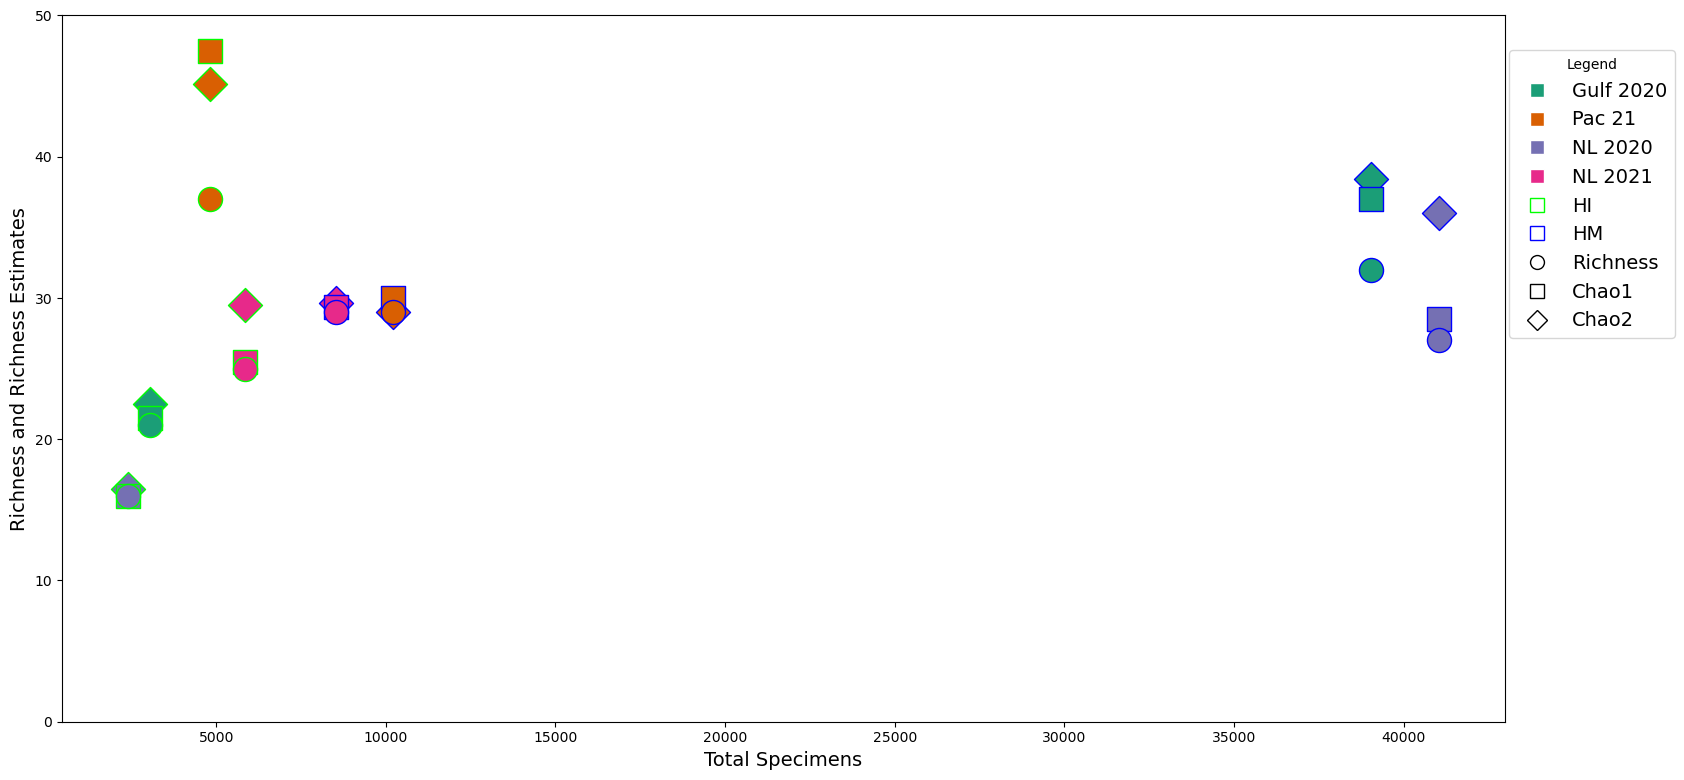

In [38]:
from matplotlib.lines import Line2D
def get_chao2(df):
    # Pivot the dataframe to get species counts for each sample
    df_agg = df.groupby(['FlowCamID', 'newName'], as_index=False)['countSample'].sum()
    
    # Pivot the dataframe to get species counts for each sample, ensuring missing species are filled with 0
    df_pivot = df_agg.pivot(index='FlowCamID', columns='newName', values='countSample').fillna(0)
    
    # Convert the counts to boolean (0 = species absent, >0 = species present)
    species_counts = df_pivot.astype(bool).sum(axis=0)  # Number of samples each species appears in
    
    # Total number of observed species (S_obs)
    S_obs = len(species_counts)
    
    # Count the number of singletons (species observed exactly once across all samples)
    n1 = sum(1 for count in species_counts if count == 1)
    
    # Count the number of doubletons (species observed exactly twice across all samples)
    n2 = sum(1 for count in species_counts if count == 2)
    print("singletons: ", n1, "doubletons: ", n2, "Species: ", S_obs)
    # Apply the Chao2 formula
    chao2 = S_obs + (n1 ** 2) / (2 * n2) if n2 > 0 else S_obs  # Avoid division by zero if n2 is zero
    
    return chao2, S_obs
hmRegionColors = {'Pac 21': '#d95f02', 'Gulf 2020':'#1b9e77', 'NL 2020': '#7570b3', 'NL 2021': '#e7298a'}
hiRegionColors = {'Pacific': '#d95f02', 'Gulf':'#1b9e77', 'NL 2020': '#7570b3', 'NL 2021': '#e7298a'}
regionYears = hi_rawcounts_df['regionYear'].unique()
fig, axes = plt.subplots(1, 1, figsize=(15, 8))
for regionYear in regionYears:
    print(regionYear)
    region_df = hi_rawcounts_df[hi_rawcounts_df['regionYear'] == regionYear].copy()
    specimen_counts = region_df['countSample'].sum()
    print('total specimen counts: ', specimen_counts)
    sample_counts = region_df.groupby('newName', as_index=False)['countSample'].sum()
    chao1 = get_chao1(sample_counts)
    region_df = region_df[['FlowCamID', 'newName', 'countSample']]
    region_df['sample_taxa'] = region_df['FlowCamID'] + '__' + region_df['newName']
    sample_taxa = region_df['sample_taxa'].unique()
    checked_list = []
    for item in sample_taxa:
        if item in checked_list:
            print('found one!!!!!!!!!!!!!!!', item)
        checked_list.append(item)
    # print(checked_list)
    chao2, S_obs = get_chao2(region_df)
    print(f"---------chao1: {chao1}, chao2: {chao2}")
    plt.scatter(specimen_counts, chao2, marker='D', s=300, edgecolor='blue', c=hiRegionColors[regionYear], label='HI ' + regionYear + ' chao2')
    plt.scatter(specimen_counts, chao1, marker='s',s=300, edgecolor='blue',  c=hiRegionColors[regionYear], label='HI ' + regionYear + ' chao1')
    plt.scatter(specimen_counts, S_obs, marker='o',s=300, edgecolor='blue',  c=hiRegionColors[regionYear], label='HI ' + regionYear + ' richness')
print('\n\nHM \n')
regionYears = hm_rawcounts_df['regionYear'].unique()
for regionYear in regionYears:
    print(regionYear)
    region_df = hm_rawcounts_df[hm_rawcounts_df['regionYear'] == regionYear].copy()
    specimen_counts = region_df['countSample'].sum()
    print('total specimen counts: ', specimen_counts)
    sample_counts = region_df.groupby('newName', as_index=False)['countSample'].sum()
    chao1 = get_chao1(sample_counts)
    region_df = region_df[['FlowCamID', 'newName', 'countSample']]
    region_df['sample_taxa'] = region_df['FlowCamID'] + '__' + region_df['newName']
    sample_taxa = region_df['sample_taxa'].unique()
    checked_list = []
    for item in sample_taxa:
        if item in checked_list:
            print('found one!!!!!!!!!!!!!!!', item)
        checked_list.append(item)
    # print(checked_list)
    chao2, S_obs = get_chao2(region_df)
    print(f"---------chao1: {chao1}, chao2: {chao2}")
    plt.scatter(specimen_counts, chao2, marker='D', s=300, edgecolor='lime', c=hmRegionColors[regionYear], label='HM ' + regionYear + ' chao2')
    plt.scatter(specimen_counts, chao1, marker='s', s=300,edgecolor='lime',  c=hmRegionColors[regionYear], label='HM ' + regionYear + ' chao1')
    plt.scatter(specimen_counts, S_obs, marker='o', s=300,edgecolor='lime',  c=hmRegionColors[regionYear], label='HM ' + regionYear + ' richness')

legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor=hmRegionColors['Gulf 2020'], markersize=10, label='Gulf 2020'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=hmRegionColors['Pac 21'], markersize=10, label='Pac 21'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=hmRegionColors['NL 2020'], markersize=10, label='NL 2020'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=hmRegionColors['NL 2021'], markersize=10, label='NL 2021'),
    
    Line2D([0], [0], marker='s', color='w', markeredgecolor='lime', markersize=10, label='HI'),
    Line2D([0], [0], marker='s', color='w', markeredgecolor='blue', markersize=10, label='HM'),
    
    Line2D([0], [0], marker='o', color='w', markeredgecolor='black', markersize=10, label='Richness'),
    Line2D([0], [0], marker='s', color='w', markeredgecolor='black', markersize=10, label='Chao1'),
    Line2D([0], [0], marker='D', color='w', markeredgecolor='black', markersize=10, label='Chao2'),
    # Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[14], markersize=10, label=special_taxa[14]),
]
# Display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(handles=legend_elements, loc='upper right', fontsize=14, title="Legend", bbox_to_anchor=(1.11, .9))
plt.ylabel('Richness and Richness Estimates', fontsize=14)
plt.xlabel('Total Specimens', fontsize=14)
plt.ylim([0, 50])
plt.show()
plt.close()

In [40]:
region_df

,FlowCamID,newName,countSample,sample_taxa
190,21-10-5-NL-S1-Z17-752-250,Acartia spp.,301,21-10-5-NL-S1-Z17-752-250__Acartia spp.
191,21-10-5-NL-S1-Z17-752-250,Aglantha spp. (medusa),2,21-10-5-NL-S1-Z17-752-250__Aglantha spp. (medusa)
192,21-10-5-NL-S1-Z17-752-250,Bivalvia (larvae),1,21-10-5-NL-S1-Z17-752-250__Bivalvia (larvae)
193,21-10-5-NL-S1-Z17-752-250,Bryozoa (larvae),28,21-10-5-NL-S1-Z17-752-250__Bryozoa (larvae)
194,21-10-5-NL-S1-Z17-752-250,Calanoida (ci-ciii),14,21-10-5-NL-S1-Z17-752-250__Calanoida (ci-ciii)
...,...,...,...,...
451,21-10-7-NL-S1-Z17-1459-250,Centropages spp.,1,21-10-7-NL-S1-Z17-1459-250__Centropages spp.
452,21-10-7-NL-S1-Z17-1459-250,Chaetognatha,14,21-10-7-NL-S1-Z17-1459-250__Chaetognatha
453,21-10-7-NL-S1-Z17-1459-250,Decapoda- non-brachyura (larvae),2,21-10-7-NL-S1-Z17-1459-250__Decapoda- non-brac...
454,21-10-7-NL-S1-Z17-1459-250,Oikopleura spp.,3,21-10-7-NL-S1-Z17-1459-250__Oikopleura spp.


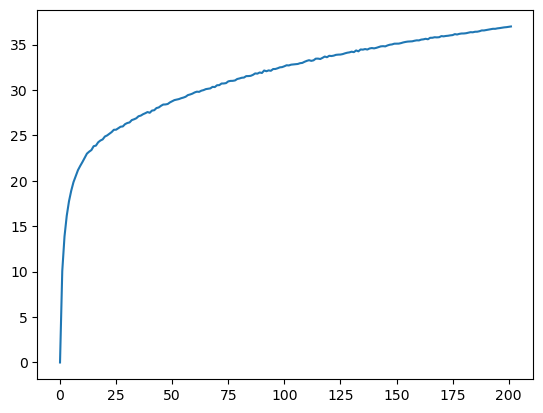

Slopes for each set of 5 consecutive values: [1.9278484848484851, 1.1928606060606064, 0.8868242424242424, 0.7083030303030302, 0.583612121212121, 0.4890848484848484, 0.42698787878787875, 0.3714121212121212, 0.3313818181818181, 0.30086060606060594, 0.26847878787878776, 0.2468727272727274, 0.22893333333333343, 0.22139393939393942, 0.21206060606060603, 0.20228484848484843, 0.19440000000000016, 0.1777333333333334, 0.17070909090909092, 0.15780606060606056, 0.14795757575757557, 0.14573939393939395, 0.13704242424242433, 0.13707272727272737, 0.13595757575757583, 0.140860606060606, 0.1433575757575757, 0.1429212121212121, 0.14454545454545448, 0.13769090909090898, 0.13711515151515147, 0.12430909090909092, 0.11525454545454554, 0.10983030303030317, 0.11006666666666687, 0.10624242424242442, 0.11273333333333342, 0.11774545454545454, 0.11867272727272732, 0.11655151515151517, 0.12049090909090908, 0.11318181818181805, 0.11328484848484839, 0.10495757575757567, 0.10170303030303018, 0.09598787878787869, 0.0

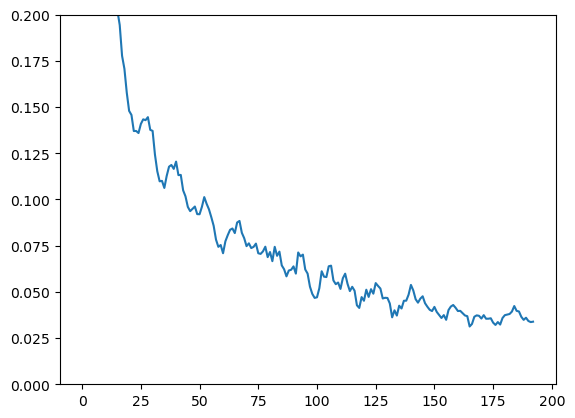

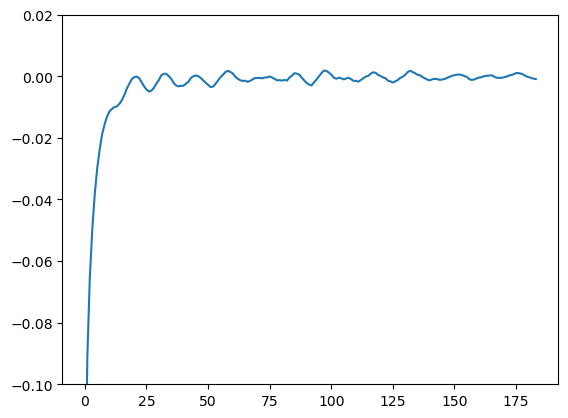

In [33]:
import numpy as np
from scipy import stats

def calculate_slopes(values, interval):
    slopes = []
    
    # Iterate through the list with a window of 5 consecutive points
    for i in range(len(values) - (interval -1)):
        # Get the set of 5 consecutive values
        x = np.array(range(i, i + interval))  # Indices (x values)
        y = np.array(values[i:i + interval])  # Actual values (y values)
        
        # Calculate the slope using linear regression (or can use np.diff for simpler method)
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        
        slopes.append(slope)
    
    return slopes


plt.plot(hm_region_richness['Pac 21'])
plt.show()
plt.close()
slopes = calculate_slopes(hm_region_richness['Pac 21'], 10)
print("Slopes for each set of 5 consecutive values:", slopes)
plt.plot(slopes)
plt.ylim([0, .2])
plt.show()
plt.close()
nested_slopes = calculate_slopes(slopes, 10)
plt.plot(nested_slopes)
plt.ylim([-.1, 0.02])
plt.show()
plt.close()

Polynomial equation: y = -0.00x^2 + 0.00x + -0.00


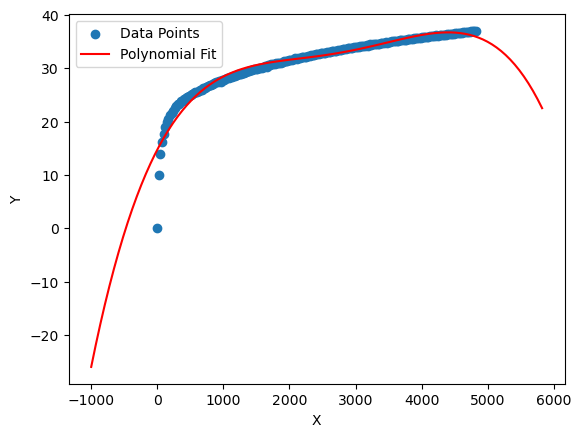

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Example data (x, y)
y = hm_region_richness['Pac 21']
increment = hm_increments['Pac 21']
x = np.array(range(len(y))) * increment
# Fit a polynomial of degree 2 (quadratic fit)
coeffs = np.polyfit(x, y, 4)

# Print the polynomial equation: y = ax^2 + bx + c
print(f"Polynomial equation: y = {coeffs[0]:.2f}x^2 + {coeffs[1]:.2f}x + {coeffs[2]:.2f}")

# Plotting the data and the polynomial fit
x_fit = np.linspace(min(x) - 1000, max(x) + 1000, 100)
y_fit = np.polyval(coeffs, x_fit)

plt.scatter(x, y, label='Data Points')
plt.plot(x_fit, y_fit, color='red', label='Polynomial Fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


In [9]:
hm_region_richness['NL 2020']

#hm_sum_counts[regionYear], hm_increments[regionYear], hm_total_species[regionYear]

[0.0,
 3.758,
 4.733,
 5.321,
 5.816,
 6.247,
 6.642,
 6.921,
 7.347,
 7.496,
 7.821,
 8.085,
 8.371,
 8.584,
 8.838,
 9.058,
 9.21,
 9.454,
 9.559,
 9.844,
 9.959,
 10.111,
 10.231,
 10.476,
 10.54,
 10.693,
 10.796,
 10.931,
 11.103,
 11.203,
 11.249,
 11.411,
 11.557,
 11.558,
 11.693,
 11.755,
 11.911,
 12.08,
 12.129,
 12.148,
 12.291,
 12.354,
 12.471,
 12.482,
 12.588,
 12.692,
 12.747,
 12.739,
 12.941,
 12.901,
 13.022,
 13.071,
 13.08,
 13.206,
 13.195,
 13.301,
 13.387,
 13.435,
 13.449,
 13.58,
 13.587,
 13.562,
 13.704,
 13.682,
 13.697,
 13.83,
 13.888,
 13.922,
 13.947,
 14.008,
 13.983,
 14.053,
 14.089,
 14.093,
 14.24,
 14.214,
 14.215,
 14.344,
 14.328,
 14.395,
 14.363,
 14.37,
 14.396,
 14.52,
 14.497,
 14.539,
 14.588,
 14.573,
 14.631,
 14.592,
 14.69,
 14.725,
 14.703,
 14.732,
 14.839,
 14.779,
 14.792,
 14.838,
 14.878,
 14.885,
 14.891,
 14.973,
 14.965,
 14.975,
 14.985,
 15.021,
 15.023,
 15.055,
 15.052,
 15.079,
 15.088,
 15.109,
 15.137,
 15.157,
 15.184

,FlowCamID,newName,regionYear,Subsample fraction,countSample
441,AMMP_PA_S04W01_20210609LT_250um,Hydrozoa (medusa),Pac 21,0.039062,2
442,AMMP_PA_S04W01_20210609LT_250um,Cirripedia (larvae),Pac 21,0.039062,5
443,AMMP_PA_S04W01_20210609LT_250um,Evadne spp.,Pac 21,0.039062,10
444,AMMP_PA_S04W01_20210609LT_250um,Podon/Pleopsis spp.,Pac 21,0.039062,33
445,AMMP_PA_S04W01_20210609LT_250um,Acartia spp.,Pac 21,0.039062,3
...,...,...,...,...,...
856,AMMP_PA_S04W01_20210610HT_250um,Decapoda- non-brachyura (larvae),Pac 21,0.125000,3
857,AMMP_PA_S04W01_20210610HT_250um,Siphonophorae (nectophore),Pac 21,1.000000,3
858,AMMP_PA_S04W01_20210610HT_250um,Decapoda- non-brachyura (larvae),Pac 21,1.000000,1
859,AMMP_PA_S04W01_20210610HT_250um,Decapoda- brachyura (larvae),Pac 21,1.000000,11


In [29]:
sampleCounts = hm_rawcounts_df[['FlowCamID', 'countSample']].groupby('FlowCamID', as_index=False)['countSample'].sum()
smallest_sample = sampleCounts['countSample'].min()
smallest_sample

203

In [31]:
rarefaction_dict = {}
regionYears = hm_rawcounts_df['regionYear'].unique()
for regionYear in regionYears:
    rarefaction_dict[regionYear] = []
    print('------------', regionYear, '------------')
    regionYear_df = hm_rawcounts_df[hm_rawcounts_df['regionYear'] == regionYear]
    samples = regionYear_df['FlowCamID'].unique()
    for sample in samples:
        sampledf = regionYear_df[regionYear_df['FlowCamID'] == sample]
        sample_counts = sampledf.groupby('newName', as_index=False)['countSample'].sum()
        print(np.sum(sample_counts['countSample'].to_numpy()))
        chao1 = get_chao1(sample_counts)
        print('sample size: ', sample_counts['countSample'].sum())
        richness = get_rarefaction_value(sample_counts, smallest_sample, 1000)
        print('richness: ', richness)
        rarefaction_dict[regionYear].append(richness)

------------ NL 2021 ------------
576
Observed species (S_obs): 18
Singletons (F1): 3
Doubletons (F2): 2
Chao1 Estimate: 19.0
sample size:  576
richness:  14.703
597
Observed species (S_obs): 19
Singletons (F1): 5
Doubletons (F2): 1
Chao1 Estimate: 24.0
sample size:  597
richness:  14.771
516
Observed species (S_obs): 18
Singletons (F1): 1
Doubletons (F2): 3
Chao1 Estimate: 18.0
sample size:  516
richness:  15.842
635
Observed species (S_obs): 18
Singletons (F1): 5
Doubletons (F2): 0
Chao1 Estimate: 28.0
sample size:  635
richness:  13.718
648
Observed species (S_obs): 17
Singletons (F1): 2
Doubletons (F2): 2
Chao1 Estimate: 17.333333333333332
sample size:  648
richness:  13.896
613
Observed species (S_obs): 19
Singletons (F1): 4
Doubletons (F2): 0
Chao1 Estimate: 25.0
sample size:  613
richness:  15.58
534
Observed species (S_obs): 19
Singletons (F1): 3
Doubletons (F2): 1
Chao1 Estimate: 20.5
sample size:  534
richness:  16.118
662
Observed species (S_obs): 20
Singletons (F1): 1
Doubl

In [32]:
rarefaction_dict

{'NL 2021': [14.703,
  14.771,
  15.842,
  13.718,
  13.896,
  15.58,
  16.118,
  16.565,
  14.018,
  12.298],
 'NL 2020': [7.996,
  7.723,
  8.438,
  8.725,
  10.683,
  9.321,
  10.54,
  8.308,
  12.464,
  8.0],
 'Gulf 2020': [8.008,
  4.738,
  11.681,
  7.397,
  8.831,
  8.076,
  14.673,
  16.007,
  9.826,
  6.448],
 'Pac 21': [20.307,
  22.932,
  21.639,
  19.294,
  18.328,
  20.61,
  21.11,
  19.842,
  21.207,
  21.242]}

In [33]:
from collections import Counter

# Example list of labels
labels = ['apple', 'banana', 'apple', 'orange', 'banana', 'banana']

# Count the occurrences of each label
label_counts = Counter(labels)

# If you want to get a list of counts (sorted by label)
counts_list = list(label_counts.values())

print(counts_list)  # Output: [2, 3, 1]


[2, 3, 1]


In [34]:
label_counts

Counter({'banana': 3, 'apple': 2, 'orange': 1})